<a href="https://colab.research.google.com/github/Caellwyn/Data-Science-Lessons/blob/main/Bonus_Lecture_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing

<u>Vocab Words!</u>:

**Document**: A text sample. Maybe a tweet, a sentence, a paragraph, an article, or maybe even a whole book.  However, it is represented as one row or sample.

**Corpus**: A complete collection of documents.  Generally a training set.

**Vocabulary** The complete list of unique words in a corpus.

**Symantics**: The meaning of words.

**Syntax**: How words are used grammatically.

## NLP is 90% data preparation

Steps:

1. Load and clean data
2. Tokenize data
3. Remove stop words
4. Normalize (stem or lemmatize)
5. Vectorize
6. Model
7. Evaluate

We will be using a 'bag of words' approach today.  The bag of words strategy does not attend to sequence or syntax, but just considers the vocabulary of the document to classify it.

The final vectorized data will have one column for each word in the vocabulary of our corpus and a number in that column representing the frequency of the word in the document the row represents.

In order to reduce the dimensionality of our data, we want to remove as many low-meaning or redundant words as possible.

In [ ]:
import pandas as pd

#open zipfiles
import zipfile

#download data from online
import requests

#Natural Language Tool Kit
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# 1. Load and clean data

In [ ]:
#import data
# archive = request.get()
data = requests.get('https://github.com/ninja-josh/image-storage/raw/main/real_and_fake_news.zip')
with open('news.zip', 'wb') as f:
  f.write(data.content)
zf = zipfile.ZipFile('/content/news.zip')
real_news = pd.read_csv(zf.open('True.csv'))
fake_news = pd.read_csv(zf.open('Fake.csv'))
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
#add labels.  Since we are detecting fake news, we set that as class 1
fake_news['label'] = 1
real_news['label'] = 0
fake_news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [ ]:
#check the shape
print(f'real_news shape: {real_news.shape}, fake_news shape: {fake_news.shape}')

real_news shape: (21417, 5), fake_news shape: (23481, 5)


In [ ]:
#check the data types and missing values
real_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [ ]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [ ]:
#check for duplicates
print(f'duplicates in real news: {real_news.duplicated().sum()}, duplicates in fake news: {fake_news.duplicated().sum()}')

duplicates in real news: 206, duplicates in fake news: 3


In [ ]:
real_news = real_news.drop_duplicates(subset=['text'])
fake_news = fake_news.drop_duplicates(subset=['text'])

A quick look shows us that the real news has the location and source before the text, while the fake news does not.  We want to standardize the data, or else our model will focus on that extra formatting to determine real news, rather than the text of the article

In [ ]:
#split the string at the first ' - ' and then just what's after it.
real_news['text'] = real_news['text'].str.split(' - ', n = 1)
#some samples did not have the intro, so x[1] doesn't work.  x[-1] covers both cases.
real_news['text'] = real_news['text'].apply(lambda x: x[-1])

In [ ]:
real_news['text']

0        The head of a conservative Republican faction ...
1        Transgender people will be allowed for the fir...
2        The special counsel investigation of links bet...
3        Trump campaign adviser George Papadopoulos tol...
4        President Donald Trump called on the U.S. Post...
                               ...                        
21412    NATO allies on Tuesday welcomed President Dona...
21413    LexisNexis, a provider of legal, regulatory an...
21414    In the shadow of disused Soviet-era factories ...
21415    Vatican Secretary of State Cardinal Pietro Par...
21416    Indonesia will buy 11 Sukhoi fighter jets wort...
Name: text, Length: 21192, dtype: object

In [ ]:
#concatenate the dataframes into one.
df = pd.concat([real_news, fake_news], axis = 0).reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38647 entries, 0 to 38646
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    38647 non-null  object
 1   text     38647 non-null  object
 2   subject  38647 non-null  object
 3   date     38647 non-null  object
 4   label    38647 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


# A little feature engineering

We want to keep information that might be included in the title, so one one common way to do that is to just concatenate the title to the start of the text.

In [ ]:
df['full_text'] = df['title'] + ' ' + df['text']
df

,title,text,subject,date,label,full_text
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",0,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",0,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",0,Trump wants Postal Service to charge 'much mor...
...,...,...,...,...,...,...
38642,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016",1,The White House and The Theatrics of ‘Gun Cont...
38643,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016",1,Activists or Terrorists? How Media Controls an...
38644,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016",1,"BOILER ROOM – No Surrender, No Retreat, Heads ..."
38645,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016",1,Federal Showdown Looms in Oregon After BLM Abu...


# 2. Tokenizing

We want to isolate each word into a separate token so we can remove stop words, punctuation, capitals, and other special characters.  Our model will represent words like 'Horse', 'horse.', and 'horse' as different words.  We want them to be considered the same.

I've also decided that I want to remove all numbers, punctuation, and special characters.  I'll use regex to only return letters and whitespace from the original document before splitting it into tokens with str.split().

I highly recommend using [Regexr.com](https://regexr.com/) to practice your regular expression and experiment to get the right expression.

In [ ]:
import re
#tokenize text, lower case, remove all symbols except letters
def clean_text(doc):
  doc = doc.lower()
  doc = re.sub(f"[^a-z\s]+", '', doc)
  tokens = doc.split()
  return tokens

In [ ]:
#series.apply() is another important tool for NLP.
df['tokens'] = df['full_text'].apply(clean_text)
df['tokens']

0        [as, us, budget, fight, looms, republicans, fl...
1        [us, military, to, accept, transgender, recrui...
2        [senior, us, republican, senator, let, mr, mue...
3        [fbi, russia, probe, helped, by, australian, d...
4        [trump, wants, postal, service, to, charge, mu...
                               ...                        
38642    [the, white, house, and, the, theatrics, of, g...
38643    [activists, or, terrorists, how, media, contro...
38644    [boiler, room, no, surrender, no, retreat, hea...
38645    [federal, showdown, looms, in, oregon, after, ...
38646    [a, troubled, king, chicagos, rahm, emanuel, d...
Name: tokens, Length: 38647, dtype: object

# 3. Remove Stopwords

We can use list comprehension to return a list of the words in each list of tokens that are not present in our list of stop words

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
#removes stop words from a list of tokens
def remove_stops(token_list):
  #this is list comprehension below.  We haven't learned it in the curriculum
  #but you can essentially put a loop in a list format to generate that list.
  #this is another very common tool for NLP.
  no_stops = [word for word in token_list if word not in stopwords]
  return no_stops

df['no_stop'] = df['tokens'].apply(remove_stops)
df['no_stop']

0        [us, budget, fight, looms, republicans, flip, ...
1        [us, military, accept, transgender, recruits, ...
2        [senior, us, republican, senator, let, mr, mue...
3        [fbi, russia, probe, helped, australian, diplo...
4        [trump, wants, postal, service, charge, much, ...
                               ...                        
38642    [white, house, theatrics, gun, control, st, ce...
38643    [activists, terrorists, media, controls, dicta...
38644    [boiler, room, surrender, retreat, heads, roll...
38645    [federal, showdown, looms, oregon, blm, abuse,...
38646    [troubled, king, chicagos, rahm, emanuel, desp...
Name: no_stop, Length: 38647, dtype: object

# 4. Lemmatizing

We can further reduce our vocabulary (dimensionality of our dataset) by lemmatizing.  This transforms words into their root.  Run and runs are transformed into 'run' since they have the same semantic meaning with only syntactic differences.

In [ ]:
#lemmatizer from the nltk package
nltk.download('omw-1.4')
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatizer.lemmatize('runs')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


'run'

In [ ]:
#function to lemmatize a list of tokens
def lemmatize_tokens(token_list):
  lemmas = [lemmatizer.lemmatize(token) for token in token_list]
  return lemmas

df['lemmas'] = df['no_stop'].apply(lemmatize_tokens)
df['lemmas']

0        [u, budget, fight, loom, republican, flip, fis...
1        [u, military, accept, transgender, recruit, mo...
2        [senior, u, republican, senator, let, mr, muel...
3        [fbi, russia, probe, helped, australian, diplo...
4        [trump, want, postal, service, charge, much, a...
                               ...                        
38642    [white, house, theatrics, gun, control, st, ce...
38643    [activist, terrorist, medium, control, dictate...
38644    [boiler, room, surrender, retreat, head, roll,...
38645    [federal, showdown, loom, oregon, blm, abuse, ...
38646    [troubled, king, chicago, rahm, emanuel, despe...
Name: lemmas, Length: 38647, dtype: object

# 5. Vectorizing

The final step in the data preparation is to transform our list of token words into vectors of floats or integers.  We will use sklearn tools for this.

## Count Vectorizing
The simplest form of bag of words vectorization is count vectorizing.  Each column of our data will be a word in the vocabulary of our training corpus.  Each value for each of our matrix will the number of times that word appears in a given document.  Obviously the vast majority of values will be zero.

We will be using an sklearn transformer for this task.

The columns should only represent words in our training corpus, since our model should not know anything about our testing data.  Therefor we need to perform our validation split before vectorizing.

NOTE: The sklearn vectorizers expect one string, not a list of tokens.  We will need to rejoin our list of tokens back into one long string.

In [ ]:
#combine token lists back into one string
df['lemmas'].str.join(' ')

0        u budget fight loom republican flip fiscal scr...
1        u military accept transgender recruit monday p...
2        senior u republican senator let mr mueller job...
3        fbi russia probe helped australian diplomat ti...
4        trump want postal service charge much amazon s...
                               ...                        
38642    white house theatrics gun control st century w...
38643    activist terrorist medium control dictate narr...
38644    boiler room surrender retreat head roll ep tun...
38645    federal showdown loom oregon blm abuse local r...
38646    troubled king chicago rahm emanuel desperate s...
Name: lemmas, Length: 38647, dtype: object

In [ ]:
#train/test split
from sklearn.model_selection import train_test_split

X = df['lemmas'].str.join(' ')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [ ]:
#vectorize the strings
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_train_vec.shape

(28985, 170807)

As you can see, the shape of X_train_vec has exploded.  It now has 170,807 columns along with the nearly 30k rows.  That represents 4,930,899,215 values.  This would not normally fit in memory, except that the vectorizer has compressed the data.  Remember we said it's mostly zeros?

This new type of array is called a 'sparse array' and sklearn models and handle them just fine.  They compress out all of the zeros and just store the non-zero elements along with a tag for where in the matrix they belong.

In [ ]:
type(X_train_vec)

scipy.sparse.csr.csr_matrix

# 6. Modeling

Modeling vectorized text is actually just like modeling any other tabular data.  Let's try our good ol' logistic regression.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train_vec, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import accuracy_score

y_preds = logreg.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_preds)
print(f'The accuracy of our logistic regression model is: {accuracy}')

The accuracy of our logistic regression model is: 0.9819913061477955


# 7. Evaluate

Let's take a quick look at a confusion matrix to see which class was harder to predict.

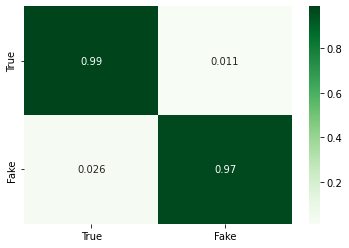

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
conf_mat = confusion_matrix(y_test, y_preds, normalize='true')

heatmap(conf_mat, annot=True, cmap='Greens',
        xticklabels=['True', 'Fake'],
        yticklabels=['True', 'Fake'])

# Next Steps

NLP goes MUCH deeper than this.  Even with a bag of words approach there are many more steps we could take:

1. Make a frequency count of words and remove words that appear only once or that are very very common.
2. Use TF-IDF vectorizing.  This is a slightly more complext vectorizing strategy.  Each column is still a word in the vocabulary, but the value is a float that represents how specific that word is to that document compared to other documents in the corpus.  Read more [here](https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d).
3. Try stemming, removing or more or fewer stop words, exploring the data for more irregularities.
4. Add more feature engineering.  We could add extra columns for the length of each document (since that is lost in the vectorizing process), the length of the title, the average length of the words in each document, the date from the date column, or some other meta-data about the text.
5. Apply other vectorization strategies that preserve sequence such as word embeddings or integer vectorization

There is also a large field of work using deep learning models, recurrent neural networks, to classify text.  [You can read more about this on my blog](https://towardsdatascience.com/pretrained-word-embeddings-using-spacy-and-keras-textvectorization-ef75ecd56360)

## Sequence to Sequence

Another large field of NLP is transformers and sequence to sequence NLP.  In this approach a model returns a text sequence rather than a single label.  This is useful in translation machines, chatbots, or voice controlled AI like Siri or Alexa.

# Final Note: Spoiler

With the exception of lemmatizing, the sklearn CountVectorizer can do all of these steps automatically, including removing punctuation, lower casing, and removing stop words.  You can also pass it a custom function if you want to do other prepreprocessing, such as lemmatizing.  Check out the documentation for the class for more information.